# KMeans Clustering And Visual Bag of Words
## Chris Tralie

We will now discuss an interesting combination between unsupervised and supervised learning known as "visual bag of words."  When we did <a href = "https://ursinus-cs477-f2021.github.io/CoursePage/ClassExercises/Week5_BagOfWords/">bag of words with text</a>, it was fairly intuitive; the words we used in our histograms were the words that occurred in our training documents.  However, with images, it's less clear what the "words" should be.  What we do is learn these "words" using KMeans.  We'll divide up an image into a bunch of tiny 11x11 grayscale patches, each of which can be thought of as a point in 121 dimensional space.  We'll then throw all of these patches together into a point cloud and perform KMeans on this point cloud.  The cluster centers that we come up with will be the "words" that we'll use when we go to classify things later.  Below is some code to sample patches and to examine the clusters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import skimage
import skimage.io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy import sparse

classes = ["airplane", "brain", "butterfly", "car_side", "chair", "electric_guitar", "revolver", "soccer_ball", "lotus", "stop_sign"]
classes = sorted(classes)

def get_patches(I, dim):
    """
    Given an an MxN single channel image I, get all dimxdim dimensional
    patches
    Parameters
    ----------
    I: ndarray(M, N)
        Single channel image
    dim: int
        Dimension of patches
    Returns
    -------
    P: ndarray((M-dim+1), (N-dim+1), dimxdim))
        Array of flattened patches
    """
    #http://stackoverflow.com/questions/13682604/slicing-a-numpy-image-array-into-blocks
    shape = np.array(I.shape*2)
    strides = np.array(I.strides*2)
    W = np.asarray(dim)
    shape[I.ndim:] = W
    shape[:I.ndim] -= W - 1
    if np.any(shape < 1):
        raise ValueError('Window size %i is too large for image'%dim)
    P = np.lib.stride_tricks.as_strided(I, shape=shape, strides=strides)
    return P


def make_dictionary(K, n_clusters, n):
    """
    Parameters
    ----------
    K: int
        Resolution of patch
    n_clusters: int
        Number of clusters to create
    n: int
        Number of patches per image
    """
    X = np.array([])
    for c in classes:
        print("Loading ", c)
        for i in range(1, 51):
            f = "images/{}/image_{:04d}.jpg".format(c, i)
            I = skimage.io.imread(f)
            I = rgb2gray(I)
            if I.dtype == np.uint8:
                I = np.array(I, dtype=float)/255
            P = get_patches(I, K)
            P = np.reshape(P, (P.shape[0]*P.shape[1], K*K))
            P = P[np.random.permutation(P.shape[0])[0:n], :]
            if X.size == 0:
                X = P
            else:
                X = np.concatenate((X, P), axis=0)
    print("Doing kmeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return kmeans


In [2]:
K = 11
n_clusters = 100
n = 100
kmeans = make_dictionary(K, n_clusters, n)

Loading  airplane
Loading  brain
Loading  butterfly
Loading  car_side
Loading  chair
Loading  electric_guitar
Loading  lotus
Loading  revolver
Loading  soccer_ball
Loading  stop_sign
Doing kmeans...


Below is what the 100 cluster centers (visual words) look like 

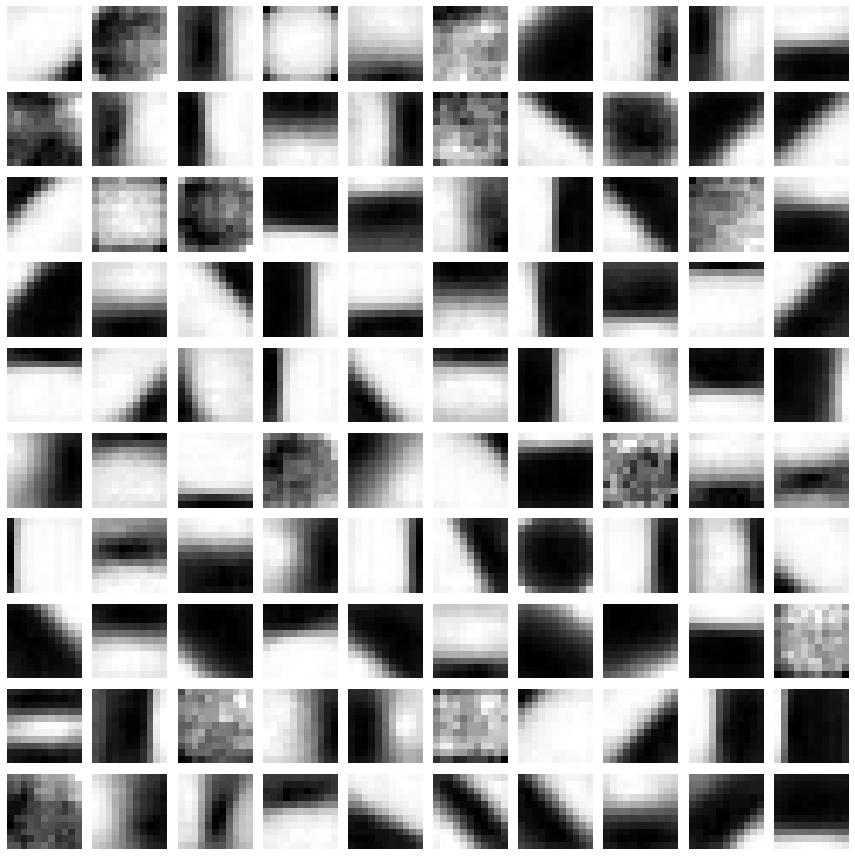

In [3]:
def display_dict_labels(kmeans):
    centers = kmeans.cluster_centers_
    N = centers.shape[0]
    K = int(np.sqrt(centers.shape[1]))
    d = int(np.ceil(np.sqrt(N)))
    plt.figure(figsize=(12, 12))
    for i in range(N):
        plt.subplot(d, d, i+1)
        x = np.reshape(centers[i, :], (K, K))
        plt.imshow(x, cmap='gray')
        plt.axis("off")
    plt.tight_layout()

display_dict_labels(kmeans)

Our next step is to train bag of words models using these words for different classes of images.  We'll load 50 images in each class.  For each, we'll sample all of its patches and find the closest word to each of them.  At that point, we can create a histogram for that image.  We'll add all of the histograms together for images in the same class, which will be our model for that class

In [4]:
def get_image_bow_histogram(f, kmeans):
    I = skimage.io.imread(f)
    I = rgb2gray(I)
    if I.dtype == np.uint8:
        I = np.array(I, dtype=float)/255
    P = get_patches(I, K)
    P = np.reshape(P, (P.shape[0]*P.shape[1], K*K))
    idx = np.array(kmeans.predict(P), dtype=int)
    s = sparse.coo_matrix((np.ones(idx.size), (np.zeros(idx.size, dtype=int), idx)), shape=(1, n_clusters))
    s = s.toarray().flatten()
    return s

In [5]:
# Now setup model for each class
models = {}
for c in classes:
    print(c)
    models[c] = np.zeros(n_clusters)
    idx = np.array([])
    for i in range(1, 51):
        models[c] += get_image_bow_histogram("images/{}/image_{:04d}.jpg".format(c, i), kmeans)
    # Convert to log Laplace smoothed probabilities
    models[c] = np.log((1 + models[c])/(np.sum(models[c]) + n_clusters))

airplane
brain
butterfly
car_side
chair
electric_guitar
lotus
revolver
soccer_ball
stop_sign


Finally, we'll create histograms for some new images and figure out the maximum likelihood class, following a procedure similar to that of <a href = "https://ursinus-cs477-f2021.github.io/CoursePage/ClassExercises/Week5_BagOfWords/">bag of words with text</a>.  We'll create a confusion matrix to keep track of which class gets classified as what

In [6]:
confusion = np.zeros((len(classes), len(classes)), dtype=int)
for i, cgt in enumerate(classes):
    print("Classifying ", cgt, "examples")
    for k in range(51, 61):
        hist = get_image_bow_histogram("images/{}/image_{:04d}.jpg".format(cgt, k), kmeans)
        # Now try to classify this with each model
        likelihoods = np.zeros(len(classes))
        for j, classj in enumerate(classes):
            model = models[classj]
            likelihoods[j] = np.sum(model*hist)
        confusion[i, np.argmax(likelihoods)] += 1

Classifying  airplane examples
Classifying  brain examples
Classifying  butterfly examples
Classifying  car_side examples
Classifying  chair examples
Classifying  electric_guitar examples
Classifying  lotus examples
Classifying  revolver examples
Classifying  soccer_ball examples
Classifying  stop_sign examples


Text(0.5, 1.0, '37.0% Accuracy')

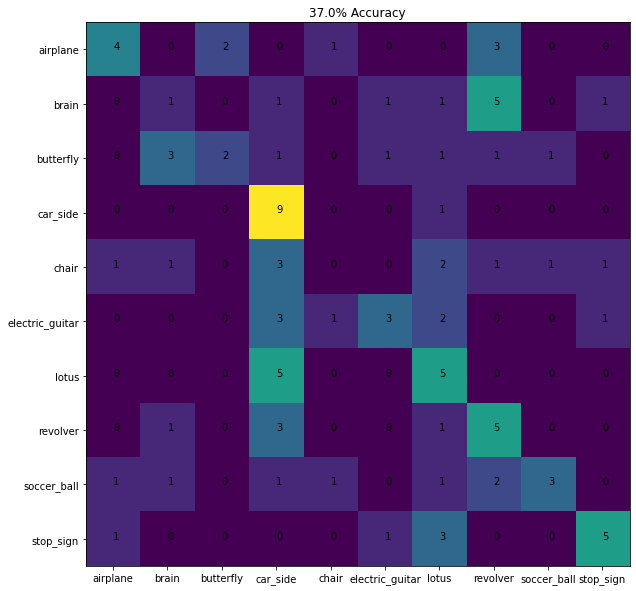

In [7]:
accuracy = np.sum(np.diag(confusion))/np.sum(confusion)

plt.figure(figsize=(10, 10))
N = len(classes)
plt.imshow(confusion)
for i in range(N):
    for j in range(N):
        plt.text(j, i, "{}".format(confusion[i,j]))
plt.xticks(np.arange(N), classes)
plt.yticks(np.arange(N), classes)
plt.title("{}% Accuracy".format(np.round(100*accuracy)))

When we look at the confusion matrix, we see that the results aren't great (37% accuracy), though we do resonably well with a few classes (car_side, lotus, revolver, stop_sign).  However, we should note that this is a tough problem, and that randomly guessing a class label for a 10 class problem would only be 10%.  So it's actually kind of amazing that we can do this well with a jumbled up histogram of visual words that are completely taken out of their spatial context.

In the last unit, we will see a much more sophisticated way to analyze images known as a "convolutional neural network," which will perform much better.  But there are some things in common; namely, it's helpful to learn little patch features in images, and piecing them together the right way in an image summary can lead towards good classifiers.

In the meantime, check out <a href = "https://www.youtube.com/watch?v=a4cFONdc6nc">this 5 minute video</a> on visual bag of words, where the author explains a slight tweak we can do with something called "TF-IDF," or "term frequency inverse document frequency" weighting.  This is to make sure that words that just happen to occur often don't give a disproportionately strong influence on the final score for a class.  The analogy in text would be the words "the" or "and", which will show up very often, but which don't tell us much about what the documents are.  You can see their code here:
https://github.com/ovysotska/in_simple_english/blob/master/bag_of_visual_words.ipynb
